useful ressources I found : https://www.kaggle.com/code/mandaloreultimate/world-of-warcraft-exploratory-analysis-wip and https://www.kaggle.com/code/servietsky/world-of-warcraft-data-analysis

Emeline Bagoris 20226056 & Simon Karl Gatzweiler xxxxxxxx

# HW2 : WoW churn predictions

-&gt; Goal 1 : recreate the processed dataset from the raw dataset
-&gt; Goal 2 : predict if a user will be playing for 6 months or longer


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split


## I. Data Preprocessing

### 1) Data exploration

In [ ]:
# Load the raw data into df
df = pd.read_csv('/work/raw_data.csv')
df.head()

,char,level,race,charclass,zone,guild,timestamp
0,59425,1,Orc,Rogue,Orgrimmar,165,01/01/08 00:02:04
1,65494,9,Orc,Hunter,Durotar,-1,01/01/08 00:02:04
2,65325,14,Orc,Warrior,Ghostlands,-1,01/01/08 00:02:04
3,65490,18,Orc,Hunter,Ghostlands,-1,01/01/08 00:02:04
4,2288,60,Orc,Hunter,Hellfire Peninsula,-1,01/01/08 00:02:09


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10826734 entries, 0 to 10826733
Data columns (total 7 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   char        int64 
 1    level      int64 
 2    race       object
 3    charclass  object
 4    zone       object
 5    guild      int64 
 6    timestamp  object
dtypes: int64(3), object(4)
memory usage: 578.2+ MB


In [ ]:
# Strip the feature names from the unwanted whitespaces at the beginning of each varname
print("Old column names with trailing spaces :", df.columns)
df.columns = df.columns.str.strip()
print("New column names :", df.columns)

Old column names with trailing spaces : Index(['char', ' level', ' race', ' charclass', ' zone', ' guild',
       ' timestamp'],
      dtype='object')
New column names : Index(['char', 'level', 'race', 'charclass', 'zone', 'guild', 'timestamp'], dtype='object')


In [ ]:
# Convert the timestamps into a DateTime object
print(df['timestamp'].dtype)
df['timestamp'] = pd.to_datetime(df['timestamp'])
print(df['timestamp'].dtype)


object
datetime64[ns]


In [ ]:
# Extract month, day and time of each entry
df['month'] = df['timestamp'].dt.month
df['day'] = df['timestamp'].dt.day
df['time'] = df['timestamp'].dt.time
df['hour'] =  df['timestamp'].dt.hour
df.head()

,char,level,race,charclass,zone,guild,timestamp,month,day,time,hour
0,59425,1,Orc,Rogue,Orgrimmar,165,2008-01-01 00:02:04,1,1,00:02:04,0
1,65494,9,Orc,Hunter,Durotar,-1,2008-01-01 00:02:04,1,1,00:02:04,0
2,65325,14,Orc,Warrior,Ghostlands,-1,2008-01-01 00:02:04,1,1,00:02:04,0
3,65490,18,Orc,Hunter,Ghostlands,-1,2008-01-01 00:02:04,1,1,00:02:04,0
4,2288,60,Orc,Hunter,Hellfire Peninsula,-1,2008-01-01 00:02:09,1,1,00:02:09,0


In [ ]:
# list the nb of unique entries for each feature
print(df.nunique())
print("There is ", df.char.nunique(), " unique players")
print("The data is collected starting from ", df.timestamp.min().date(), " to ", df.timestamp.max().date())

char           37354
level             80
race               5
charclass         10
zone             158
guild            420
timestamp    1826400
month             12
day               31
time           86399
hour              24
dtype: int64
There is  37354  unique players
The data is collected starting from  2008-01-01  to  2008-12-31


In [ ]:
# categorical data values
print("race has ", df.race.nunique(), "unique values : ", df.race.unique())
print("charclass has ", df.charclass.nunique(), "unique values : ", df.charclass.unique())
#print("zone has ", df.zone.nunique(), "unique values : ", df.zone.unique())

race has  5 unique values :  ['Orc' 'Tauren' 'Troll' 'Undead' 'Blood Elf']
charclass has  10 unique values :  ['Rogue' 'Hunter' 'Warrior' 'Shaman' 'Warlock' 'Druid' 'Priest' 'Mage'
 'Paladin' 'Death Knight']


In [ ]:
# check the distribution of players levels 
# out of memory
# df.plot.hist(column=["level"], figsize=(10, 8))

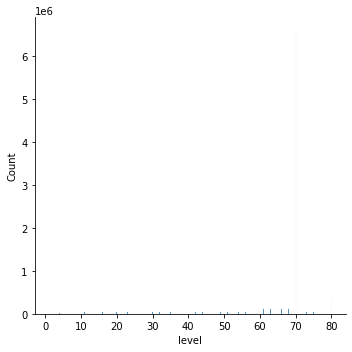

In [ ]:
sns.displot(df,x="level")

In [ ]:
'''out of memory
import plotly.express as px

fig = px.bar(df, x='race', y='charclass', color = 'month',
             hover_data=['month', 'char'],
             labels={'char':'Actif Players', 'charclass': 'Character Class', 'rece' : 'Character Race'}, height=500)
fig.show()
'''

"out of memory\nimport plotly.express as px\n\nfig = px.bar(df, x='race', y='charclass', color = 'month',\n             hover_data=['month', 'char'],\n             labels={'char':'Actif Players', 'charclass': 'Character Class', 'rece' : 'Character Race'}, height=500)\nfig.show()\n"

### 2) Data cleaning

In [ ]:
# Is there missing values ? 
df.isna().sum().sum()

0

### 3) Data&nbsp;aggregation

In [ ]:
# Perform aggregation of information related to each player
# Get the level max of each player 
char_max_level = df.groupby('char')['level'].max()
# Get the nb of connections to server of each player 
# After checking, the nb of timestamp per player is equal to the nb of day per player 
char_nb_connections = df.groupby('char')['timestamp'].count()
#tmp = df.groupby(by = ['char'])['day'].nunique()
# Get the guild
char_guild = df.groupby('char')['guild'].max()
# Get the last month of connection of each player
char_max_month = df.groupby('char')['month'].max()
# Get the game starting month of each player
char_min_month = df.groupby('char')['month'].min()
# Get the average hour to start playing per player
char_avg_hour = df.groupby('char')['hour'].mean()


In [ ]:
# Group playerbase by character ID for the number of unique days they have played
total_timestamps = df.groupby(by = ['char'])['day'].count()

### 4) Final touch to obtain the same preprocessed dataset

There is 37354 unique char id in the preprocessed dataset given by the teacher

The features of the preprocessed dataset given by the teacher are :
char_id(string), guild (boolean), total_timestamps(int), unique_days(int), max_level(int), 
min_month(int), max_month(int), Average_Hour(int) and Average_Playing_density(int)

In [ ]:
# Average_Hour
# Average_Playing_density

In [ ]:
# create new dataframe with the aggregated list
data = {'char_id':char_nb_connections.index,
        'guild':char_guild.values,
        'total_timestamps':total_timestamps.values,
        'unique_days':char_nb_connections.values,
        'max_level':char_max_level.values,
        'max_month':char_max_month.values,
        'min_month':char_min_month.values,
        'Average_Hour':char_avg_hour
        }

average_hours_df = pd.DataFrame(data = data)

### 5) Data transformation

In [ ]:
# Encoding for categorical variables (guild is a boolean)
average_hours_df['guild'] = np.where(average_hours_df['guild']>-1, 1, 0)

### 6) Create the target variable

The label of the preprocessed dataset given by the teacher is : Playing_after_6_months(boolean)

In [ ]:
# since its a logistic regression,it takes binary labels
# we should add 0 for player with nb of month played <6 and 1 for >6months ?
# but it doesn't make much sense since we only have the data for the year 2018
# any player starting to play after july will be labeled 0 ...
# anyway we can compute the difference between the fist month of connection and the last one but its not precise
# or we can compute number of days between first and last connection and divide by 30

In [ ]:
average_hours_df['Playing_after_6_months'] = np.where((average_hours_df['max_month']-average_hours_df['min_month'])>=5, 1, 0)
average_hours_df.head()

,char_id,guild,total_timestamps,unique_days,max_level,max_month,min_month,Average_Hour,Playing_after_6_months
char,,,,,,,,,
2,2,1,1,1,18,12,12,10.000000,0
7,7,1,655,655,71,12,1,14.174046,1
9,9,1,2739,2739,70,6,1,11.450894,1
10,10,0,674,674,61,11,7,18.057864,0
19,19,1,3001,3001,70,12,1,9.517827,1


## II. Machine Learning

In [ ]:
# since its a logistic regression,it takes binary labels
# we should add 0 for player with nb of month played <6 and 1 for >6months ?
# but it doesn't make much sense since we only have the data for the year 2018
# any player starting to play after july will be labeled 0 ...
# anyway we can compute the difference between the fist month of connection and the last one but its not precise
# or we can compute number of days between first and last connection and divide by 30

### 2) Train the model

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, GridSearchCV, KFold, StratifiedKFold, RepeatedStratifiedKFold
from statistics import mean
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from scipy.stats import loguniform
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

In [ ]:
preprocessed_df = pd.read_csv("/work/preprocessed.csv", index_col=0)
y = preprocessed_df['Playing_after_6_months']
preprocessed_df.drop(columns=['Playing_after_6_months', 'min_month', 'max_month', 'char_id'], inplace=True)
X = preprocessed_df
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

### a)Logistic Regression+Regularization

In [ ]:
preprocessed_df.head()

,guild,total_timestamps,unique_days,max_level,Average_Hour,Average_Playing_density
0,1,1,1,18,0.166667,0.032787
1,1,655,50,71,2.183333,0.136612
2,1,2739,133,70,3.432331,0.726776
3,0,674,49,61,2.292517,0.321311
4,1,3001,149,70,3.356823,0.407104


In [ ]:
# Implement Logistic Regression with regularization, KNN classifier and SVM

In [ ]:
preprocessed_df.isnull().sum().sum()

preprocessed_df.columns

Index(['guild', 'total_timestamps', 'unique_days', 'max_level', 'Average_Hour',
       'Average_Playing_density'],
      dtype='object')

In [ ]:
# pipeline for numerical transformer
numeric_features = ['guild','total_timestamps', 'unique_days', 'max_level', 'Average_Hour', 'Average_Playing_density']
numeric_transformer = Pipeline(steps = [('scaler', StandardScaler())])
# construct the column transformer
preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features)])

In [ ]:
# assemble the end-to-end pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor), 
    #('classifier', KNeighborsClassifier(n_neighbors = 3))
    ('classifier', LogisticRegression())
])

In [ ]:
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.991112538815719

In [ ]:
param_grid = [{'classifier': [LogisticRegression()],
               'classifier__solver': ['lbfgs'],
               'classifier__penalty': ['l2'],
               'classifier__C': [0.001,0.01,0.1,1,10,100]},
               #'classifier__C': loguniform.rvs(1e-3, 1e0, size=100)},
              ]

In [ ]:
#GridSearchCV(estimator, parameters to tune, cross validation fold)
grid_search = GridSearchCV(clf,param_grid,cv=10)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('scaler',
                                                                                          StandardScaler())]),
                                                                         ['guild',
                                                                          'total_timestamps',
                                                                          'unique_days',
                                                                          'max_level',
                                                                          'Average_Hour',
                                                                          'Average_Playing_density'])])),
                                       ('classifier', LogisticRegression())]),
     

In [ ]:
grid_search.best_score_

1.0

In [ ]:
grid_search.best_params_

{'classifier': LogisticRegression(C=100),
 'classifier__C': 100,
 'classifier__penalty': 'l2',
 'classifier__solver': 'lbfgs'}

In [ ]:
grid_search.score(X_test,y_test)

1.0

### KNN Neighbors

In [ ]:
# Standardize the training set using StandardScaler()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Test the accuracy of the KNN model on the standardized training set
neighbors = np.arange(1,15,2)
cross_val_scores =[]
skfold=StratifiedKFold(n_splits = 10, shuffle=False)

for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors = i)
    scores = cross_val_score(knn,X_train_scaled,y_train,cv=skfold)
    cross_val_scores.append(np.mean(scores))
print(cross_val_scores)  

print("best cross-validation score:{:.3f}".format(np.max(cross_val_scores)))
best_n_neighbors = neighbors[np.argmax(cross_val_scores)]
print("best n_neighbors:{}".format(best_n_neighbors))

knn_best = KNeighborsClassifier(n_neighbors = best_n_neighbors)
knn_best.fit(X_train,y_train)

print("test-set score:{:.3f}".format(knn_best.score(X_test,y_test)))

[0.9767980284394199, 0.9773337171057243, 0.9777618297329826, 0.9783686156748852, 0.9775476714877754, 0.9769408600629783, 0.9767267273006659]
best cross-validation score:0.978
best n_neighbors:7
test-set score:0.904


### SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
# train the model on train set
model = SVC()
model.fit(X_train, y_train)
 
# print prediction results
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.88      0.98      0.92      7288
           1       0.87      0.51      0.64      2051

    accuracy                           0.87      9339
   macro avg       0.87      0.74      0.78      9339
weighted avg       0.87      0.87      0.86      9339



In [ ]:
# defining parameter range
param_grid_svm = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001]}
 
grid_svm = GridSearchCV(SVC(), param_grid_svm, refit = True, verbose = 3)
 
# fitting the model for grid search
grid_svm.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ....................C=0.1, gamma=1;, score=0.780 total time=  15.0s
[CV 2/5] END ....................C=0.1, gamma=1;, score=0.780 total time=  15.0s
[CV 3/5] END ....................C=0.1, gamma=1;, score=0.780 total time=  15.3s
[CV 4/5] END ....................C=0.1, gamma=1;, score=0.780 total time=  15.2s


KeyboardInterrupt: 

In [ ]:
grid_svm.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
grid_svm.best_score_

In [ ]:
grid_svm.score(X_test, y_test)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3936dca8-42ca-41a4-aad6-22f3c31c57fb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>